In [42]:
import os
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
x = torch.load("images_data.pt")

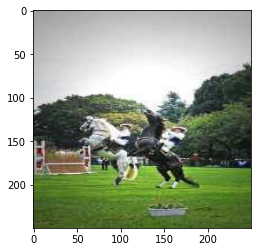

In [3]:
plt.imshow(x[1].permute(1, 2, 0))
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import time
import random 


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.5, num_filters = 1) -> None:
        super().__init__()
        self.features = nn.Sequential(
        nn.Conv2d(3, int(64*num_filters), kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(int(64*num_filters), int(192*num_filters), kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(int(192*num_filters), int(384*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(int(384*num_filters), int(256*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(int(256*num_filters), int(256*num_filters), kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(int(256*num_filters) * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train(criterion, model, loader, optimizer, device=None):
    model.train()
    N = len(loader)
    for i, (images, labels) in enumerate(loader): 
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def eval_loss_and_error(criterion, model, loader, device=None):
    model.eval()
    l, accuracy, ndata = 0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            l += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            accuracy += pred.eq(target.view_as(pred)).sum().item()
            ndata += len(data)
    
    return l/ndata, accuracy/ndata*100

In [5]:
from torchvision import models
# Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
 
    def forward(self, x):
        return self.sigm(self.base_model(x))
 
# Initialize the model
model = Resnext50(20)
# Switch model to the training mode
model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [6]:
if torch.backends.mps.is_built():
    device = torch.device("mps")
    print("M1 pro GPU is activated")
else:
    device = torch.device("cuda")
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device:{torch.cuda.current_device()}")
        
    print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

M1 pro GPU is activated


In [10]:
x_batch = x[:5]
y = model(x_batch)
y.shape

torch.Size([5, 20])

In [11]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [12]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [13]:

for i in range(df_train.shape[0]):
    df_train.Labels[i] = [int(j) for j in df_train.Labels[i].split()]
max_i = 0
for i in df_train.Labels:
    max_i = max(max_i, max(i))
min_i = 19
for i in df_train.Labels:
    min_i = min(min_i, min(i))
min_i
1
for i in range(1, max_i+1):
    df_train[f'{i}'] = 0
for i in range(df_train.shape[0]):
    for j in df_train.Labels[i]:
        df_train[f"{j}"][i] = 1
df_train

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_77114/1448968353.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[f"{j}"][i] = 1


,ImageID,Labels,Caption,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.jpg,[1],Woman in swim suit holding parasol on sunny day.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.jpg,"[1, 19]",A couple of men riding horses on top of a gree...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2.jpg,[1],They are brave for riding in the jungle on tho...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.jpg,"[8, 3, 13]",a black and silver clock tower at an intersect...,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,4.jpg,"[8, 3, 7]",A train coming to a stop on the tracks out side.,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29991,29995.jpg,"[8, 1, 2]",A picture of a truck that is in the middle of ...,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29992,29996.jpg,[1],A plate topped with a pizza being cut with a s...,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29993,29997.jpg,[1],A man riding a snowboard on top of snow.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29994,29998.jpg,[1],This photo shows people skiing in the mountains.,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_train.iloc[0][3:]

1     1
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: 0, dtype: object

In [31]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, images, csv, train, test):
        self.csv = csv # df_train
        self.train = train # boolean
        self.test = test # boolean
        self.images = images

        self.all_image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']

        self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))

        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45)
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[:])
            self.labels = list(self.all_labels[:])
             # define the test transforms
            self.transform = transforms.Compose([
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = self.transform(image)
        targets = self.labels[index]
        caption = self.captions[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            # 'caption' : caption
        }

In [32]:
train_data = ImageDataset(
    x, df_train, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    x, df_train, train=False, test=False
)
train_loader = DataLoader(
    train_data, 
    batch_size=32,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=32,
    shuffle=False
)

Number of training images: 25496
Number of validation images: 4500


In [41]:
for i, data in enumerate(train_loader):
    print(data["image"].shape)
    break

torch.Size([32, 3, 250, 250])


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_77114/2385168544.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


In [44]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [46]:
for it in range(5):

    for i, data in enumerate(train_loader):
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        print(i/(30000/32))
        

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_77114/2385168544.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


RuntimeError: Input type (MPSFloatType) and weight type (torch.FloatTensor) should be the same

In [47]:
torch.FloatTensor

torch.FloatTensor